In [1]:
import numpy as np
import pandas as pd
import darts
from darts import TimeSeries
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
#import seaborn as sns
from datetime import datetime
from darts.dataprocessing.transformers import Scaler
from darts.metrics import smape, r2_score, rmse

from darts.models import (
    AutoARIMA,
    Prophet,
    RNNModel,
    NBEATSModel,
    BlockRNNModel,
    TFTModel,
)

from tqdm import tqdm
import numpy as np

In [2]:
df = pd.read_csv('../input/rossmann-store-sales/train.csv', parse_dates=['Date'])
df.sample(10)
df = pd.concat([df.drop(columns='StateHoliday'), pd.get_dummies(df.StateHoliday, prefix='Holiday')], axis=1)

In [3]:
store = pd.read_csv('../input/rossmann-store-sales/store.csv')

In [8]:
def get_sample(num):
    sample = df[df.Store == num]
    series = TimeSeries.from_dataframe(sample, 'Date', 'Sales')

    train, test = series.split_before(pd.Timestamp("20150601"))

    transformer = Scaler()
    train_transformed = transformer.fit_transform(train)
    test_transformed = transformer.transform(test)

    series_customers = TimeSeries.from_dataframe(sample, time_col='Date', value_cols='Customers')
    series_open = TimeSeries.from_dataframe(sample, time_col='Date', value_cols='Open')
    series_promo = TimeSeries.from_dataframe(sample, time_col='Date', value_cols='Promo')
    series_school = TimeSeries.from_dataframe(sample, time_col='Date', value_cols='SchoolHoliday')
    series_weekday = TimeSeries.from_dataframe(sample, time_col='Date', value_cols='DayOfWeek')
    series_holiday_a = TimeSeries.from_dataframe(sample, time_col='Date', value_cols='Holiday_a')
    series_holiday_b = TimeSeries.from_dataframe(sample, time_col='Date', value_cols='Holiday_b')
    series_holiday_c = TimeSeries.from_dataframe(sample, time_col='Date', value_cols='Holiday_c')

    customers_transformed = transformer.transform(series_customers)

    covariates = series_customers.stack(series_open)
    covariates = covariates.stack(series_promo)
    covariates = covariates.stack(series_school)
    covariates = covariates.stack(series_weekday)
    covariates = covariates.stack(series_holiday_a)
    covariates = covariates.stack(series_holiday_b)
    covariates = covariates.stack(series_holiday_c)

    train_covariates, test_covariates = covariates.split_before(pd.Timestamp("20150601"))

    return train_transformed, test_transformed, covariates

In [9]:
train, test, covariates = get_sample(10)

In [10]:
def rmspe(actual, pred):
    return np.sqrt(np.mean( ((actual - pred) / actual)**2)) 

def smape(actual, pred):
    return np.mean(np.abs(pred - actual) / ((np.abs(actual) + np.abs(pred))/2)) * 100

def evaluate_model(model, train, test):
    model.fit(train)
    pred = model.predict(len(test))
    test = test.pd_dataframe()
    pred = pred.pd_dataframe()

    test.columns = ['Actual']
    pred.columns = ['Pred']

    df = pd.concat([test, pred], axis=1)
    df = df[df.Actual > 0]
    return smape(df.Actual.values, df.Pred.values), rmspe(df.Actual.values, df.Pred.values)

In [11]:
train_transformed, test_transformed, covariates = get_sample(10)
auto_arima = AutoARIMA()
rmspe_score, smape_score = evaluate_model(auto_arima, train_transformed, test_transformed )
rmspe_score, smape_score

(16.47940106567434, 0.18430909224215103)

In [12]:
store_num_list = pd.read_csv('../input/store_list.csv').Store.values

## 1. Prophet

### 1.1 Naive Prophet Model

In [13]:
smape_list = []
rmspe_list = []
from darts.metrics.metrics import mape
for num in tqdm(store_num_list):
    train_transformed, test_transformed, covariates = get_sample(num)
    prophet = Prophet()
    smape_score, rmspe_score = evaluate_model(prophet, train_transformed, test_transformed )
    smape_list.append(smape_score)
    rmspe_list.append(rmspe_score)


  0%|          | 0/100 [00:00<?, ?it/s]00:27:12 - cmdstanpy - INFO - Chain [1] start processing
00:27:12 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 1/100 [00:00<01:28,  1.12it/s]00:27:12 - cmdstanpy - INFO - Chain [1] start processing
00:27:12 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 2/100 [00:01<00:56,  1.74it/s]00:27:13 - cmdstanpy - INFO - Chain [1] start processing
00:27:13 - cmdstanpy - INFO - Chain [1] done processing
  3%|▎         | 3/100 [00:01<00:49,  1.96it/s]00:27:13 - cmdstanpy - INFO - Chain [1] start processing
00:27:13 - cmdstanpy - INFO - Chain [1] done processing
  4%|▍         | 4/100 [00:02<00:42,  2.23it/s]00:27:13 - cmdstanpy - INFO - Chain [1] start processing
00:27:14 - cmdstanpy - INFO - Chain [1] done processing
  5%|▌         | 5/100 [00:02<00:39,  2.40it/s]00:27:14 - cmdstanpy - INFO - Chain [1] start processing
00:27:14 - cmdstanpy - INFO - Chain [1] done processing
  6%|▌         | 6/100 [00:02<00:40,  2.32it/s]0

17.03961507611494 3.558108815281411 25.601667562870812 8.088705992990423


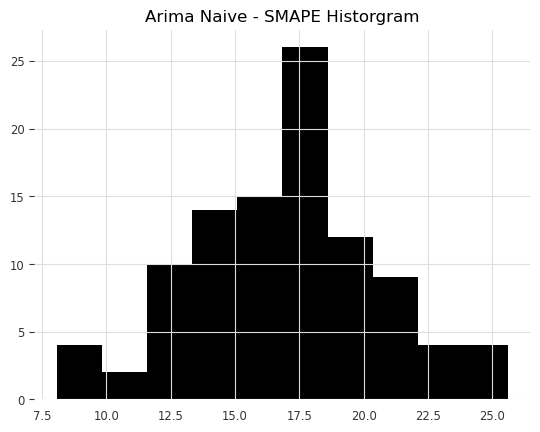

In [14]:
print(np.mean(smape_list), np.std(smape_list), np.max(smape_list), np.min(smape_list))
plt.hist(smape_list)
plt.title('Arima Naive - SMAPE Historgram')
plt.show()

0.2043810567715515 0.04465863704913343 0.36606684275627505 0.10477305163886752


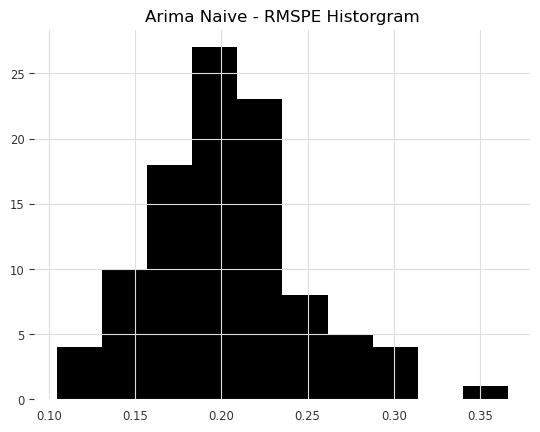

In [15]:
print(np.mean(rmspe_list), np.std(rmspe_list), np.max(rmspe_list), np.min(rmspe_list))
plt.hist(rmspe_list)
plt.title('Arima Naive - RMSPE Historgram')
plt.show()

In [16]:
len(rmspe_list), len(smape_list)

(100, 100)

In [17]:
res1 = pd.DataFrame(
    {
        'rmspe' : rmspe_list,
        'smape' : smape_list,
    }
)

### 1.2 Covrariate Prophet Model

In [18]:
def evaluate_covariates_model(model, train, test, covariates):
    model.fit(train, future_covariates=covariates)
    pred = model.predict(len(test), future_covariates=covariates)
    test = test.pd_dataframe()
    pred = pred.pd_dataframe()

    test.columns = ['Actual']
    pred.columns = ['Pred']

    df = pd.concat([test, pred], axis=1)
    df = df[df.Actual > 0]
    return smape(df.Actual.values, df.Pred.values), rmspe(df.Actual.values, df.Pred.values)

In [19]:
smape_list = []
rmspe_list = []
for num in tqdm(store_num_list):

    train_transformed, test_transformed, covariates = get_sample(num)
    prophet = Prophet()
    mape_score, rmse_score  = evaluate_covariates_model(prophet, train_transformed, test_transformed, covariates )
    smape_list.append(mape_score)
    rmspe_list.append(rmse_score)


  0%|          | 0/100 [00:00<?, ?it/s]00:27:52 - cmdstanpy - INFO - Chain [1] start processing
00:27:52 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 1/100 [00:00<00:51,  1.93it/s]00:27:52 - cmdstanpy - INFO - Chain [1] start processing
00:27:52 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 2/100 [00:00<00:44,  2.22it/s]00:27:53 - cmdstanpy - INFO - Chain [1] start processing
00:27:53 - cmdstanpy - INFO - Chain [1] done processing
  3%|▎         | 3/100 [00:01<00:46,  2.11it/s]00:27:53 - cmdstanpy - INFO - Chain [1] start processing
00:27:53 - cmdstanpy - INFO - Chain [1] done processing
  4%|▍         | 4/100 [00:01<00:43,  2.21it/s]00:27:53 - cmdstanpy - INFO - Chain [1] start processing
00:27:54 - cmdstanpy - INFO - Chain [1] done processing
  5%|▌         | 5/100 [00:02<00:41,  2.29it/s]00:27:54 - cmdstanpy - INFO - Chain [1] start processing
00:27:54 - cmdstanpy - INFO - Chain [1] done processing
  6%|▌         | 6/100 [00:02<00:44,  2.13it/s]0

4.945281108195381 1.3876699831090877 11.045099034470566 3.0054126334873477


(array([12., 37., 30., 10.,  4.,  1.,  4.,  0.,  0.,  2.]),
 array([ 3.00541263,  3.80938127,  4.61334991,  5.41731855,  6.22128719,
         7.02525583,  7.82922447,  8.63319311,  9.43716175, 10.24113039,
        11.04509903]),
 <BarContainer object of 10 artists>)

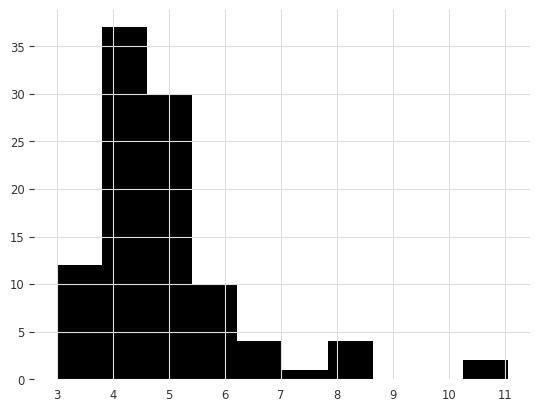

In [20]:
print(np.mean(smape_list), np.std(smape_list), np.max(smape_list), np.min(smape_list))
plt.hist(smape_list)

0.062313173908654235 0.01931103028355804 0.14161067872420754 0.036733372881653445


(array([15., 33., 28., 11.,  5.,  2.,  0.,  4.,  1.,  1.]),
 array([0.03673337, 0.0472211 , 0.05770883, 0.06819656, 0.0786843 ,
        0.08917203, 0.09965976, 0.11014749, 0.12063522, 0.13112295,
        0.14161068]),
 <BarContainer object of 10 artists>)

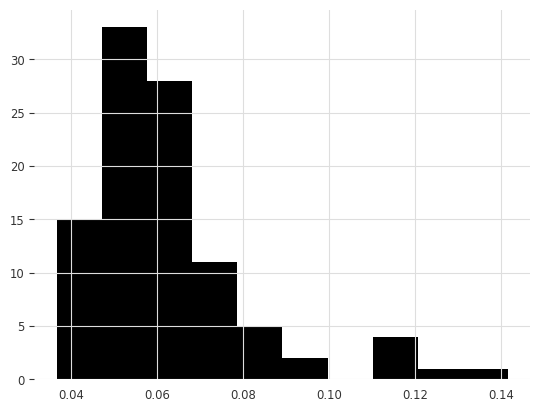

In [21]:
print(np.mean(rmspe_list), np.std(rmspe_list), np.max(rmspe_list), np.min(rmspe_list))
plt.hist(rmspe_list)

In [22]:
res2 = pd.DataFrame(
    {
        'rmspe' : rmspe_list,
        'smape' : smape_list,
    }
)

In [23]:
res2

,rmspe,smape
0,0.062790,5.011583
1,0.046605,3.685819
2,0.060533,4.430835
3,0.046212,3.570881
4,0.063969,5.358496
...,...,...
95,0.057386,4.670913
96,0.056414,4.530130
97,0.036733,3.005413
98,0.052127,4.062261


In [24]:
res_naive = res1
res_naive['Store'] = store_num_list
res_cov = res2
res_cov['Store'] = store_num_list
result = pd.merge(res_naive, res_cov, left_on='Store', right_on='Store')
result = result.set_index('Store')
result = pd.merge(result, store[['Store','StoreType']], left_on='Store', right_on='Store')
result.to_csv('../output/prophet_result.csv')
result.head()

,Store,rmspe_x,smape_x,rmspe_y,smape_y,StoreType
0,10,0.149594,11.895035,0.062790,5.011583,a
1,62,0.170809,13.964291,0.046605,3.685819,a
2,110,0.168144,13.359221,0.060533,4.430835,a
3,163,0.115724,9.181443,0.046212,3.570881,a
4,300,0.198166,16.465733,0.063969,5.358496,a


00:30:38 - cmdstanpy - INFO - Chain [1] start processing
00:30:38 - cmdstanpy - INFO - Chain [1] done processing


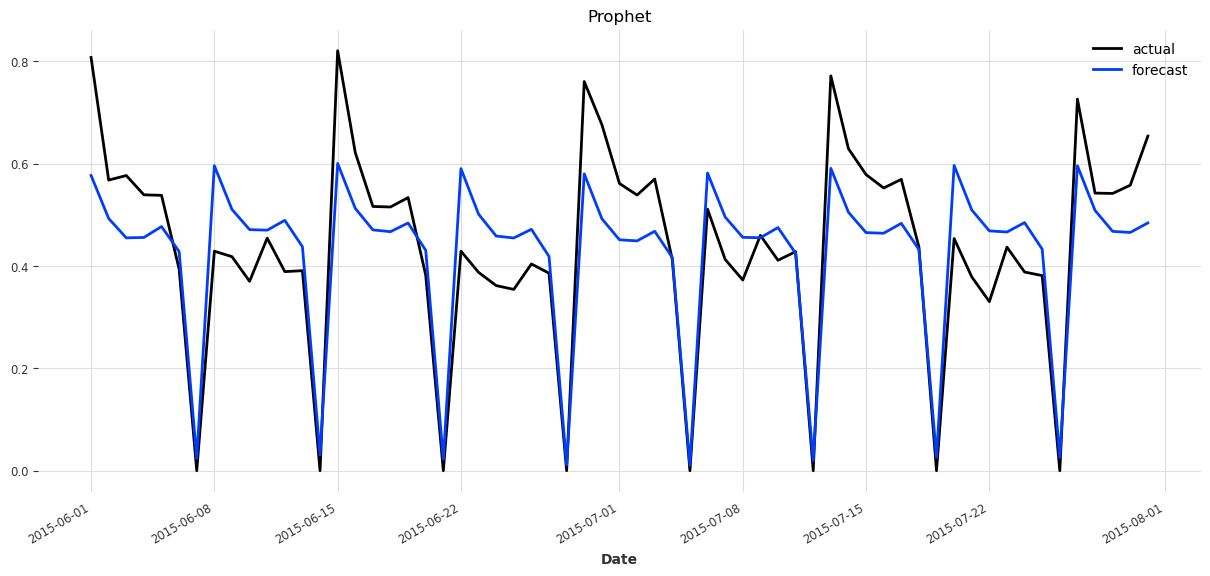

In [29]:
prophet = Prophet()
prophet.fit(train_transformed)
pred_demand_covs = prophet.predict(len(test_transformed))

plt.figure(figsize=(15, 6))
test_transformed.plot(label="actual")
pred_demand_covs.plot(label="forecast")
plt.title('Prophet')
plt.show()

00:33:26 - cmdstanpy - INFO - Chain [1] start processing
00:33:26 - cmdstanpy - INFO - Chain [1] done processing


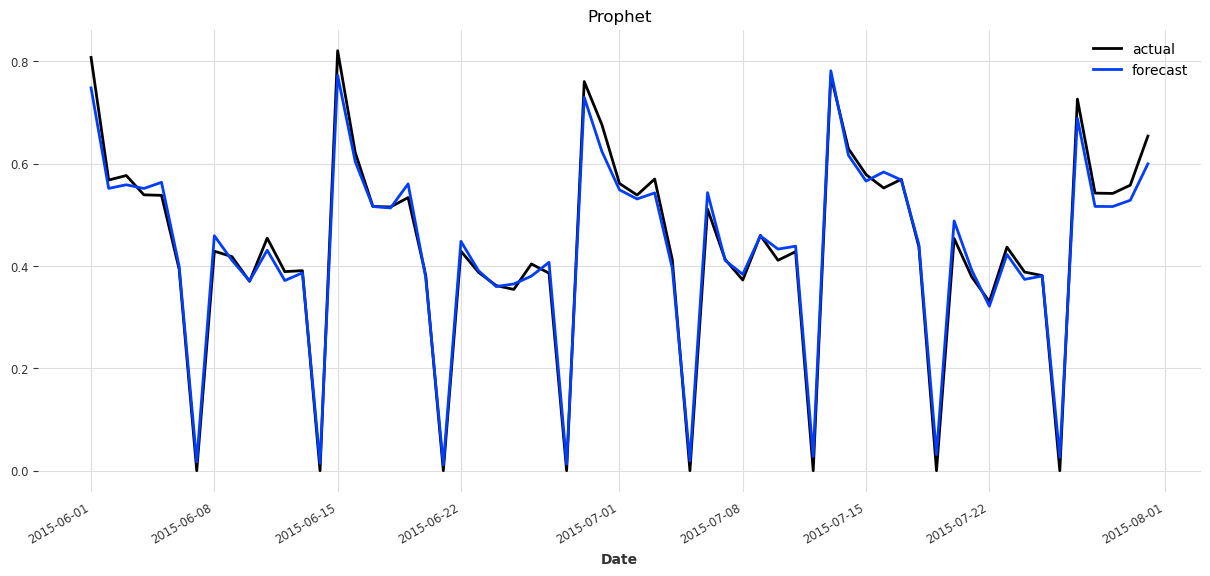

In [33]:
train_covariates, test_covariates = covariates.split_before(pd.Timestamp("20150601"))

prophet = Prophet()
prophet.fit(train_transformed, future_covariates=covariates)
pred_demand_covs = prophet.predict(len(test_transformed), future_covariates=covariates)

plt.figure(figsize=(15, 6))
test_transformed.plot(label="actual")
pred_demand_covs.plot(label="forecast")
plt.title('Prophet')
plt.show()

In [30]:
res1.mean()

rmspe      0.204381
smape     17.039615
Store    585.390000
dtype: float64

In [34]:
res2.mean()

rmspe      0.062313
smape      4.945281
Store    585.390000
dtype: float64